# Régression supervisée

## Import des outils / jeu de données

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split

from src.utils import init_notebook
from sklearn.linear_model import LogisticRegression

In [4]:
init_notebook()

In [5]:
df = pd.read_csv(
    "data/kickstarter_1.csv",
    parse_dates=True,
)
event_times = df["day_succ"]
event_observed = df["Status"]

event_times_no_censoring = df["day_succ"][df["Status"] == 1]
event_observed_no_censoring = df["Status"][df["Status"] == 1]

On ne s'intéresse qu'aux variables suivantes

In [6]:
df = df[
    [
        "day_succ",
        "Status",
        "has_video",
        "facebook_connected",
        "goal",
        "facebook_friends",
    ]
]

# Régression logistique

Nous cherchons à prévoir si le projet sera financé dans les 60 jours impartis ou non.

In [20]:
X = df.drop(["day_succ", "Status"], axis=1)
y = event_observed

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [22]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

In [23]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.629940119760479

Nous obtenons une accuracy de 62%, ce qui est relativement peu.

In [33]:
# Get coefficients
log_reg_coeff = pd.DataFrame(
    {"Variable": [col for col in X.columns], "Coefficient": log_reg.coef_[0].tolist()}
)
log_reg_coeff

,Variable,Coefficient
0,has_video,0.848165
1,facebook_connected,-0.009586
2,goal,-6.582300
3,facebook_friends,0.366086


## Régression linéaire

Nous cherchons à déterminer quelle est la durée de financement d'un projet, sachant qu'il a été financé.

In [40]:
# Redefine variables
X = df[event_observed == 1].drop(["Status", "day_succ"], axis=1)
y = df["day_succ"][event_observed == 1]

Text(0.5, 0, 'Nombre de jours avant le financement')

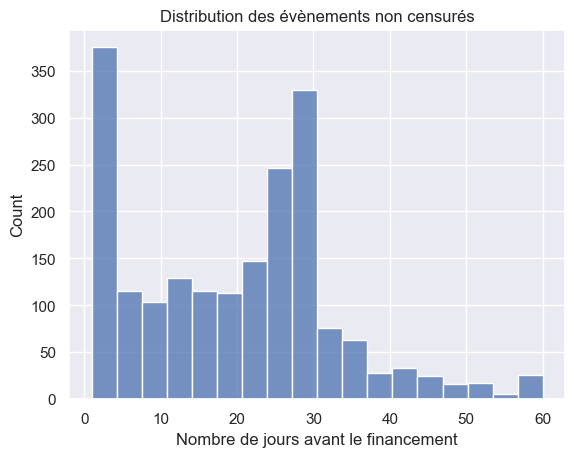

In [45]:
sns.histplot(y)
plt.title("Distribution des évènements non censurés")
plt.xlabel("Nombre de jours avant le financement")

### Modèle explicatif

In [41]:
# Add constant
X = sm.add_constant(X)

# Define and fit model
linear_explic = sm.OLS(y, X).fit()

# Predict
y_pred_explic = linear_explic.predict(X)

# Calculate residuals
residuals_explic = y_pred_explic - y

#### Diagnostic

In [42]:
linear_explic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               day_succ   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     8.626
Date:                Mon, 15 Jan 2024   Prob (F-statistic):           6.71e-07
Time:                        23:50:54   Log-Likelihood:                -7852.4
No. Observations:                1962   AIC:                         1.571e+04
Df Residuals:                    1957   BIC:                         1.574e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 17.1439      1.006     17.048      0.000      15.172      19.116
has_video              2.5783      0.904      2.853      0.004       0.806       4.351
facebook_connected     1.2968      0.670      1.936      0.053      -0.017       2.610
goal                  32.5965     10.546      3.091      0.002      11.914      53.279
facebook_friends       0.8303      0.311      2.670      0.008       0.220       1.440
==============================================================================
Omnibus:                       44.454   Durbin-Watson:                   0.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.567
Skew:                           0.367   Prob(JB):                     7.73e-11
Kurtosis:                       2.827   Cond. No.                         56.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* Un objectif financier (`goal`) ambitieux signifie plus de temps avant d'atteindre le financement. C'est la variable la plus influente.
* Avoir une **vidéo pour promouvoir le projet est très favorable**.
* Plus le compte facebook du projet a d'abonnés, plus la durée de financement est courte. 
* `facebook_connected` engendre un problème de multicolinéarité avec `facebook_friends` et n'est donc pas significative. On la retire de l'analyse.

In [43]:
# Drop variable
X = X.drop("facebook_connected", axis=1)

Text(0.5, 1.0, 'Distribution des résidus')

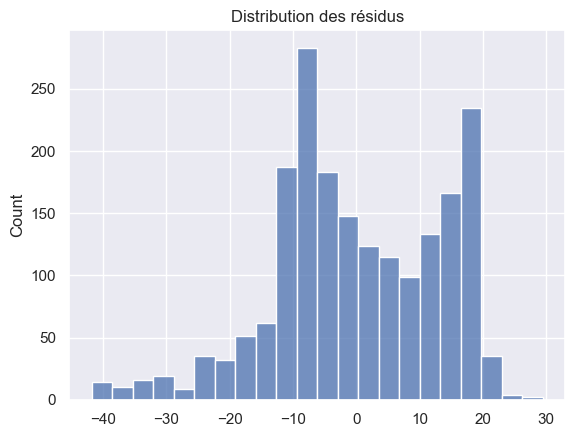

In [46]:
sns.histplot(residuals_explic)
plt.title("Distribution des résidus")

### Modèle prédictif

In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [48]:
linear = LinearRegression(fit_intercept=False)
linear.fit(X_train, y_train)

LinearRegression(fit_intercept=False)

In [49]:
# Get coefficients
coefficients_df = pd.DataFrame(
    {"Variable": [col for col in X.columns], "Coefficient": linear.coef_.tolist()}
)
coefficients_df

,Variable,Coefficient
0,const,17.190159
1,has_video,3.026888
2,goal,19.910159
3,facebook_friends,1.212761


In [50]:
# Evaluate model prediction capacity
y_pred = linear.predict(X_test)

linear_mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
linear_mae = mean_absolute_error(y_true=y_test, y_pred=y_pred)

print(f"Mean squared error = {round(linear_mse)}")
print(f"Mean absolute error = {round(linear_mae)}")

Mean squared error = 188
Mean absolute error = 12


En moyenne, le modèle de régression linéaire parvient à prévoir la durée nécessaire au financement à 12 jours près. 

## Forêt aléatoire

In [51]:
# Create and train a Random Forest Regressor
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [52]:
# Get feature importances
feature_importances = random_forest.feature_importances_

# Display feature importances
importances_df = pd.DataFrame(
    {"Variable": [col for col in X.columns], "Importance": feature_importances.tolist()}
)
importances_df

,Variable,Importance
0,const,0.000000
1,has_video,0.033123
2,goal,0.415424
3,facebook_friends,0.551453


In [53]:
# Evaluate model prediction capacity
y_pred_rf = random_forest.predict(X_test)

# Calculate Mean Squared Error and Mean Absolute Error
rf_mse = mean_squared_error(y_true=y_test, y_pred=y_pred_rf)
rf_mae = mean_absolute_error(y_true=y_test, y_pred=y_pred_rf)

print(f"Random Forest Mean Squared Error = {round(rf_mse)}")
print(f"Random Forest Mean Absolute Error = {round(rf_mae)}")

Random Forest Mean Squared Error = 211
Random Forest Mean Absolute Error = 11


En moyenne, le modèle de forêt aléatoire parvient à prévoir la durée nécessaire au financement à 11 jours près.  

# Réseau de neurones

In [56]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [57]:
# Create and train a Multi-layer Perceptron Regressor
mlp_regressor = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)
mlp_regressor.fit(X_train, y_train)

# Evaluate model prediction capacity
y_pred_mlp = mlp_regressor.predict(X_test)

# Calculate Mean Squared Error and Mean Absolute Error
mlp_mse = mean_squared_error(y_true=y_test, y_pred=y_pred_mlp)
mlp_mae = mean_absolute_error(y_true=y_test, y_pred=y_pred_mlp)

print(f"MLP Regressor Mean Squared Error = {round(mlp_mse)}")
print(f"MLP Regressor Mean Absolute Error = {round(mlp_mae)}")


MLP Regressor Mean Squared Error = 190
MLP Regressor Mean Absolute Error = 12


En moyenne, le réseau de neurones parvient à prévoir la durée nécessaire au financement à 12 jours près.  

---

# Bilan

| Régression logistique | Accuracy     |
|:----------------------|-------------:|
| Le projet sera-t-il financé ?   |     62% |

**Tableau.** Modèle de prévision et MAE correspondante obtenue sur l'ensemble de test

| Modèle               | MAE          |
|:----------------------|-------------:|
| Régression Linéaire   |     12 jours |
|**Forêt Aléatoire**       |     **11 jours** |
| Réseau de Neurones    |     12 jours |

**On conservera donc le modèle de forêt aléatoire pour la prédiction.**